# Ex situ GIWAXS processing

# GIWAXS raw data processing & exporting notebook
In this notebook you output xr.DataSets stored as .zarr stores containing all your raw,
remeshed (reciprocal space), and caked CMS GIWAXS data. Saving as a zarr automatically converts the array to a dask array

## Imports

In [1]:
### Imports:
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr
import PyHyperScattering as phs
import fabio
import gc
from tqdm.auto import tqdm  # progress bar loader!

print(f"Don't worry about the above warnings/errors... using PyHyperScattering version: {phs.__version__}!")

Imports failed.  Are you running on a machine with proper libraries for databroker, tiled, etc.?


UNSUPPORTED (log once): buildComputeProgram: cl2Metal failed
/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/repos/PyHyperScattering/src/PyHyperScattering/integrate.py:3: UserWarning: Could not import CuPy or ndigpu.  If you expect this machine to support CuPy, check dependencies.  Falling back to scikit-image/numpy CPU integration.
  from PyHyperScattering.WPIntegrator import WPIntegrator
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_csr: cannot import name 'ocl_azim_csr' from 'pyFAI' (/Users/andrew/conda_install/envs/pyhyper/lib/python3.12/site-packages/pyFAI/__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_azim_lut for: cannot import name 'ocl_azim_lut' from 'pyFAI' (/Users/andrew/conda_install/envs/pyhyper/lib/python3.12/site-packages/pyFAI/__init__.py)
ERROR:pygix.transform:Unable to import pyFAI.ocl_sort for: cannot import name 'ocl_sort' from 'pyFAI' (/Users/andrew/conda_install/envs/pyhyper/lib/python3.12/site-packages/pyFAI/__in

Don't worry about the above warnings/errors... using PyHyperScattering version: 0.2.3+131.g08c3943!


## Defining some objects

### Define & check paths

In [67]:
# I like pathlib for its readability & checkability, it's also necessary for the loadSeries function later on
# Replace the paths with the ones relevant to your data, you can use the ".exists()" method to make sure you defined a path correctly
suitePath = pathlib.Path('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/giwaxs_suite')
xenocsPath = suitePath.joinpath('raw_data/xenocs')
rawPath = xenocsPath.joinpath('PM6_2024C1_2024-06-03')
outPath = suitePath.joinpath('processed_data/xenocs')

# Select poni & mask filepaths
# poniFile = xenocsPath.joinpath('xenocs_100sdd.poni')
# poniFile = xenocsPath.joinpath('xenocs_120sdd.poni')
poniFile = xenocsPath.joinpath('xenocs_380sdd.poni')

# Colormap
cmap = plt.cm.turbo.copy()
cmap.set_bad('black')

In [68]:
pilatus1m = 0.000172  # cms detector 
eiger2_1m = 0.000075  # xenocs xeuss 3.0 detector

def poni_centers(poniFile, pix_size=eiger2_1m):
    """
    Returns poni center value and the corresponding pixel position. Default pixel size is 172 microns (Pilatus 1M)
    
    Inputs: poniFile as pathlib path object to the poni file
    Outputs: ((poni1, y_center), (poni2, x_center))
    """
    
    with poniFile.open('r') as f:
        lines = list(f.readlines())
    poni1_str = lines[6]
    poni2_str = lines[7]

    poni1 = float(poni1_str.split(' ')[1])
    poni2 = float(poni2_str.split(' ')[1])

    y_center = poni1 / pix_size
    x_center = poni2 / pix_size
        
    return ((poni1, y_center), (poni2, x_center))

display(poni_centers(poniFile))

((0.06749999999999999, 900.0), (0.00375, 50.0))

In [69]:
[f.name for f in rawPath.glob('*')]

['PM6_5CNCF_scan2',
 'PM6_5CNCB_380sdd_scan2',
 'PM6_5CNCB_380sdd_scan3',
 'PM6_p5CN2CF3CB_380sdd_scan1',
 '.DS_Store',
 'PM6_5CNCB_scan2',
 'PM6_0CNCF_380sdd_scan1',
 'PM6_5CNCF_380sdd_scan1',
 'PM6_p5CN2CF3CB_scan1',
 'PM6_0CNCB_scan1',
 'PM6_0CNCB_380sdd_scan3',
 'PM6_0CNCF_scan1',
 'PM6_0CNCB_380sdd_scan2',
 'PM6_5CNCB_380sdd_scan1',
 'PM6_5CNCF_scan1',
 'PM6_0CNCF_380sdd_scan3',
 'PM6_p5CN2CF3CB_380sdd_scan2',
 'PM6_5CNCB_scan1',
 'PM6_0CNCF_380sdd_scan2',
 'PM6_p5CN2CF3CB_380sdd_scan3',
 'PM6_5CNCF_380sdd_scan2',
 'PM6_5CNCF_380sdd_scan3',
 'PM6_p5CN2CF3CB_scan2',
 'PM6_0CNCB_scan2',
 'PM6_0CNCF_scan2',
 'PM6_0CNCB_380sdd_scan1']

### Define metadata naming scheme & initialize loaders

In [70]:
# Make separate sets of folders if necessary
all_folders = set(rawPath.glob('PM6*'))  # all folders
far_folders = set(rawPath.glob('PM6*380sdd*'))  # all folders containing 380sdd
near_folders = all_folders.difference(far_folders)  # all folders not containing 380sdd
display([f.name for f in sorted(near_folders)])

['PM6_0CNCB_scan1',
 'PM6_0CNCB_scan2',
 'PM6_0CNCF_scan1',
 'PM6_0CNCF_scan2',
 'PM6_5CNCB_scan1',
 'PM6_5CNCB_scan2',
 'PM6_5CNCF_scan1',
 'PM6_5CNCF_scan2',
 'PM6_p5CN2CF3CB_scan1',
 'PM6_p5CN2CF3CB_scan2']

In [71]:
# sample_folders = sorted(near_folders)  # normal GIWAXS at sdd = 120 mm
sample_folders = sorted(far_folders)  # far out GIWAXS at sdd = 380 mm

# display(sample_folders)
for sample_folder in sample_folders:
    display([f.name for f in sorted(sample_folder.glob('*edf'))])

['PM6_0CNCB_380sdd_scan1_0_00000.edf',
 'PM6_0CNCB_380sdd_scan1_0_00001.edf',
 'PM6_0CNCB_380sdd_scan1_0_vd_00000-00001.edf']

['PM6_0CNCB_380sdd_scan2_0_00000.edf',
 'PM6_0CNCB_380sdd_scan2_0_00001.edf',
 'PM6_0CNCB_380sdd_scan2_0_vd_00000-00001.edf']

['PM6_0CNCB_380sdd_scan3_0_00000.edf',
 'PM6_0CNCB_380sdd_scan3_0_00001.edf',
 'PM6_0CNCB_380sdd_scan3_0_vd_00000-00001.edf']

['PM6_0CNCF_380sdd_scan1_0_00000.edf',
 'PM6_0CNCF_380sdd_scan1_0_00001.edf',
 'PM6_0CNCF_380sdd_scan1_0_vd_00000-00001.edf']

['PM6_0CNCF_380sdd_scan2_0_00000.edf',
 'PM6_0CNCF_380sdd_scan2_0_00001.edf',
 'PM6_0CNCF_380sdd_scan2_0_vd_00000-00001.edf']

['PM6_0CNCF_380sdd_scan3_0_00000.edf',
 'PM6_0CNCF_380sdd_scan3_0_00001.edf',
 'PM6_0CNCF_380sdd_scan3_0_vd_00000-00001.edf']

['PM6_5CNCB_380sdd_scan1_0_00000.edf',
 'PM6_5CNCB_380sdd_scan1_0_00001.edf',
 'PM6_5CNCB_380sdd_scan1_0_vd_00000-00001.edf']

['PM6_5CNCB_380sdd_scan2_0_00000.edf',
 'PM6_5CNCB_380sdd_scan2_0_00001.edf',
 'PM6_5CNCB_380sdd_scan2_0_vd_00000-00001.edf']

['PM6_5CNCB_380sdd_scan3_0_00000.edf',
 'PM6_5CNCB_380sdd_scan3_0_00001.edf',
 'PM6_5CNCB_380sdd_scan3_0_vd_00000-00001.edf']

['PM6_5CNCF_380sdd_scan1_0_00000.edf',
 'PM6_5CNCF_380sdd_scan1_0_00001.edf',
 'PM6_5CNCF_380sdd_scan1_0_vd_00000-00001.edf']

['PM6_5CNCF_380sdd_scan2_0_00000.edf',
 'PM6_5CNCF_380sdd_scan2_0_00001.edf',
 'PM6_5CNCF_380sdd_scan2_0_vd_00000-00001.edf']

['PM6_5CNCF_380sdd_scan3_0_00000.edf',
 'PM6_5CNCF_380sdd_scan3_0_00001.edf',
 'PM6_5CNCF_380sdd_scan3_0_vd_00000-00001.edf']

['PM6_p5CN2CF3CB_380sdd_scan1_0_00000.edf',
 'PM6_p5CN2CF3CB_380sdd_scan1_0_00001.edf',
 'PM6_p5CN2CF3CB_380sdd_scan1_0_vd_00000-00001.edf']

['PM6_p5CN2CF3CB_380sdd_scan2_0_00000.edf',
 'PM6_p5CN2CF3CB_380sdd_scan2_0_00001.edf',
 'PM6_p5CN2CF3CB_380sdd_scan2_0_vd_00000-00001.edf']

['PM6_p5CN2CF3CB_380sdd_scan3_0_00000.edf',
 'PM6_p5CN2CF3CB_380sdd_scan3_0_00001.edf',
 'PM6_p5CN2CF3CB_380sdd_scan3_0_vd_00000-00001.edf']

In [72]:
# set ex situ metadata filename naming schemes:
# md_naming_scheme = ['material', 'solvent', 'scan_num', 'misc', 'detector_pos']
md_naming_scheme = ['material', 'solvent', 'sdd', 'scan_num', 'misc', 'detector_pos']


# Initalize CMSGIWAXSLoader objects with the above naming schemes
loader = phs.load.CMSGIWAXSLoader(md_naming_scheme=md_naming_scheme)

## Load & process raw data

### Load Xenocs data into list(s) of DataArrays, set your incident_angle!

In [73]:
def load_xenocs_folders(sample_folders, files_to_load, incident_angle, phs_loader):
    """
    Loader for Xenocs Xeuss 3.0 GIWAXS output (Eiger2 1M detector)

    Inputs:
    - sample_folders (pathlib.path): A directory that contains all the xenocs data you want to load together (must all be same incident angle)
    - files_to_load (list): List of strings, chosen files to load for xenocs up to ['hi', 'lo', 'vd']
                            Do ['hi'] if you only took single images in the default detection
                            Do ['hi', 'lo'] or ['hi', 'lo', 'vd'] if you want to use stitching 
                            Note: 'vd' is the default stitched output for the xenocs, which is good but doesnt averate the two images together
    - incident_angle (float): Your incident angle, important for later transformations
    - phs_loader (phs.load.CMSGIWAXSLoader): PyHyperScattering CMSGIWAXSLoader object, with a metadata naming scheme ideally!

    Outputs:
    - loaded_DAs: dictionary with the xenocs 'files_to_load' type as keys for a list of corresponding DataArrays
    """

    # Load data in each Xenocs sample folder
    # Just uncomment corresponding lines if you don't want/have all the data files to load
    
    # Create dictionary with empty lists of each xenocs type to append to
    loaded_DAs = {}
    for file_to_load in files_to_load:
        loaded_DAs[file_to_load] = []
    
    # Load data into dictionary lists
    for sample_folder in sample_folders:
        for file_to_load in files_to_load:
            if file_to_load == 'hi':
                file = sorted(sample_folder.glob('*_00000.edf'))[0]
            elif file_to_load == 'lo':
                file = sorted(sample_folder.glob('*_00001.edf'))[0]
            elif file_to_load == 'vd':
                file = sorted(sample_folder.glob('*-00001.edf'))[0]
            else:
                print("invalide xenocs file_to_load option: ['hi', 'lo', 'vd']")
        
            DA = loader.loadSingleImage(file)
        
            DA.attrs['incident_angle'] = incident_angle
        
            DA = DA.where(DA!=-1)
        
            loaded_DAs[file_to_load].append(DA)

    return loaded_DAs

In [74]:
incident_angle = 0.15  # Set your incident angle you used for this data!
files_to_load = ['hi', 'lo', 'vd']  # Choose types of xenocs images to load

loaded_DAs = load_xenocs_folders(sample_folders, files_to_load, incident_angle, loader)
# loaded_DAs

hi_DAs = loaded_DAs['hi']
lo_DAs = loaded_DAs['lo']
vd_DAs = loaded_DAs['vd']

In [76]:
# # Optionally check the lists
# display(hi_DAs)
# display(len(hi_DAs))

### Combine two Xenocs Xeuss 3.0 detector images (stitch gap & average counts)
Benefit here versus the default 'vd' images from Xenocs: **average overlapping data!**

Xenocs Xeuss 3.0 'line eraser' moves det0xvd (0.75) and det0zvd (-4.125), corresponding to pixel shifts:

'lo_DA' (_00001.edf') compared to 'hi_DA' (_00000.edf): Detector moves 10 pixels to the right, 55 pixels down. 

As currently written, this code maintains the original hi_DA shape. The extra 55 pixels at the bottom and the extra 10 pixels to the right are thrown out.

#### Checking original data

In [ ]:
# fab_img = fabio.open(hi_file)
# fab_img.header
# (0.75e-3) / eiger2_1m  # use det0xvd shift: so a 10 pixel shift for the hi-lo gap?

In [30]:
# lo_DA = lo_DAs[0]
# hi_DA = hi_DAs[0]

In [28]:
# plt.close('all')
# cmin = lo_DA.quantile(0.01)
# cmax = lo_DA.quantile(0.99)
# lo_DA.plot.imshow(cmap=plt.cm.turbo, norm=plt.Normalize(cmin,cmax), origin='upper')
# plt.show()

In [29]:
# plt.close('all')
# cmin = hi_DA.quantile(0.01)
# cmax = hi_DA.quantile(0.99)
# hi_DA.plot.imshow(cmap=plt.cm.turbo, norm=plt.Normalize(cmin,cmax), origin='upper')
# plt.show()

In [ ]:
# # confirm that vd stitched file is NOT what we want 

# plt.close('all')
# fig, ax = plt.subplots()
# hi_DA.sel(pix_x=slice(10, 80), pix_y=slice(30, 605)).sum('pix_x').plot.line(ax=ax)
# vd_DA.sel(pix_x=slice(10, 80), pix_y=slice(30, 605)).sum('pix_x').plot.line(ax=ax, linestyle='--')
# plt.show()

#### Combine images & check

In [77]:
# Load mask & hi_lo shift:
# Below are the correct values the xenocs xeuss 3.0 shift
y_shift = 55 
x_shift = 10

In [78]:
# Stitch & average the two images
stitched_DAs = []
for tup in zip(lo_DAs, hi_DAs):
    lo_DA = tup[0].copy()
    hi_DA = tup[1].copy()
    
    # Shift lo DA to match hi da
    shifted_lo_DA = lo_DA.shift(pix_x=x_shift, pix_y=y_shift)

    # Stich missing data in hi_DA from shifted lo_DA:
    filled_hi_DA = hi_DA.combine_first(shifted_lo_DA)

    # Average data that is in both images:
    # Make boolean mask; true where there is overlap between images, false where there isn't
    overlap_mask = hi_DA.notnull() & shifted_lo_DA.notnull()  
    # Keep original combined data where there isn't overlap, average with shifted lo_DA otherwise
    stitched_DA = filled_hi_DA.where(~overlap_mask, (filled_hi_DA + shifted_lo_DA) / 2)   

    # # Mask area below horizon, this will be above pix_y ~ 895:    
    # stitched_DA = stitched_DA.where(stitched_DA.pix_y<895)
    
    # Record stitched DAs if good:
    stitched_DAs.append(stitched_DA)


    
# # If you want to double check where the overlap
# # It may likely be evident in the actual data too, where it appears smoother vs not
# overlap_mask.plot.imshow()
# plt.show()

In [ ]:
stitched_DAs[0]

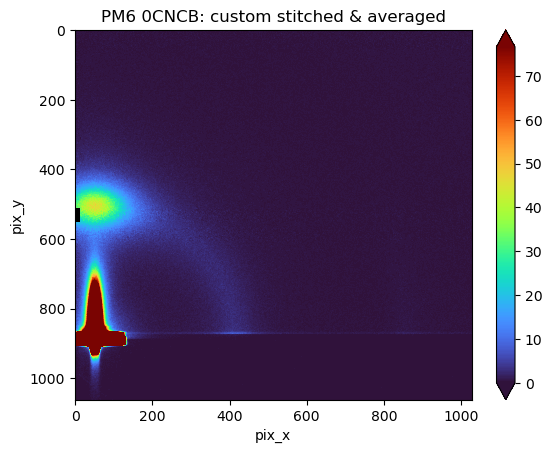

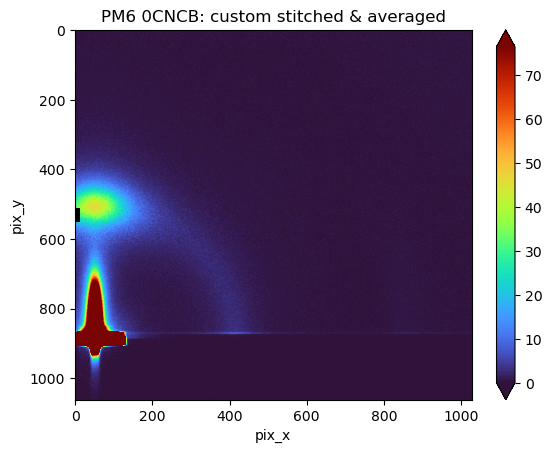

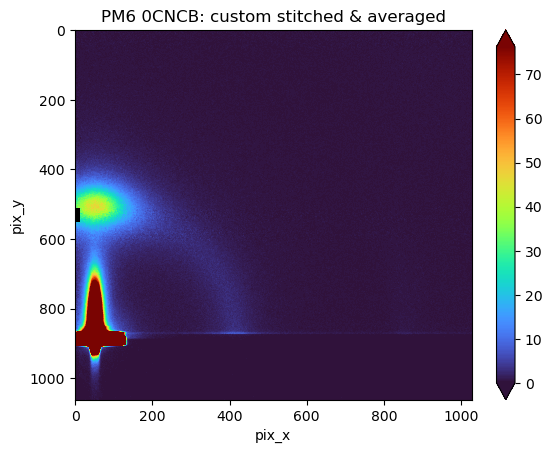

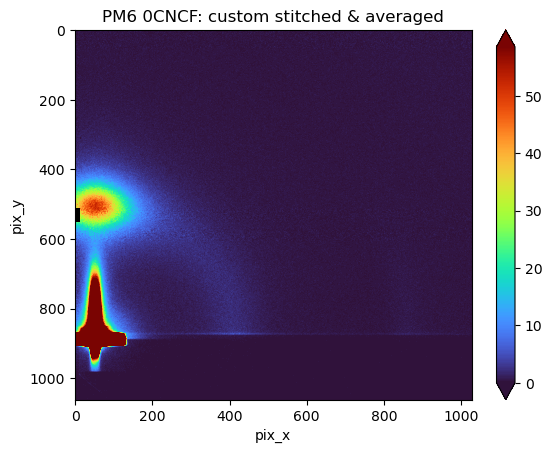

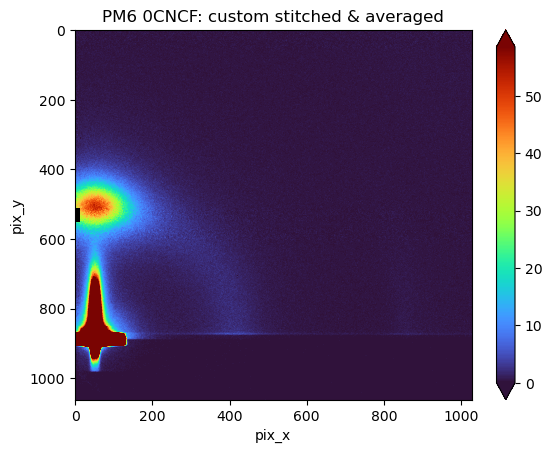

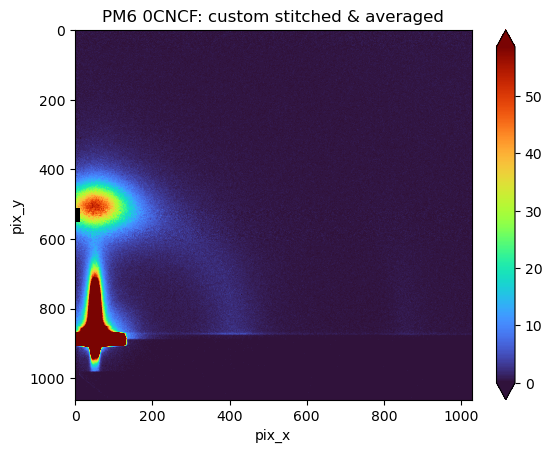

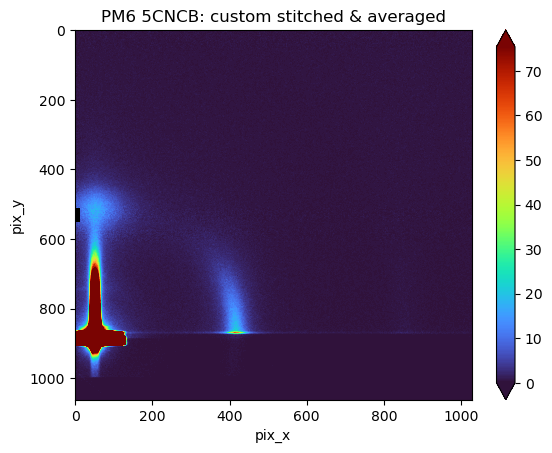

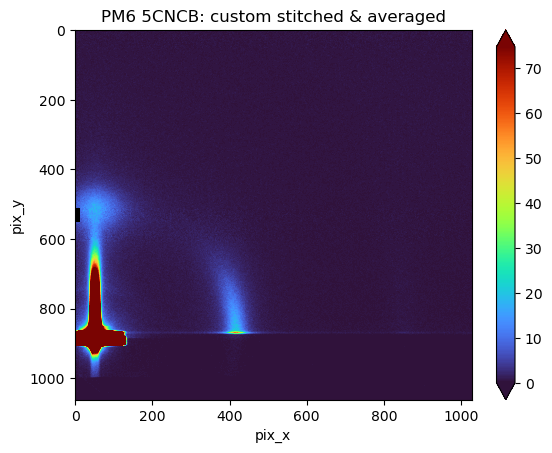

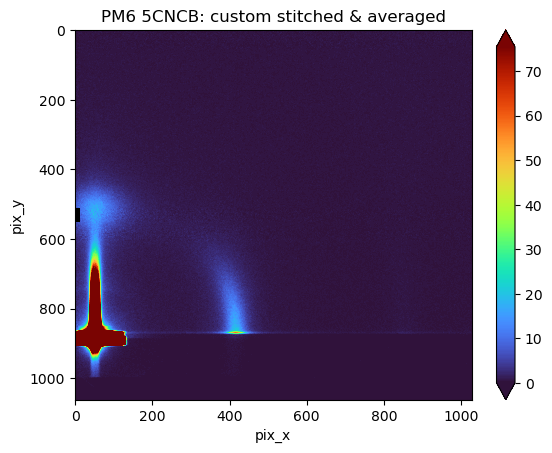

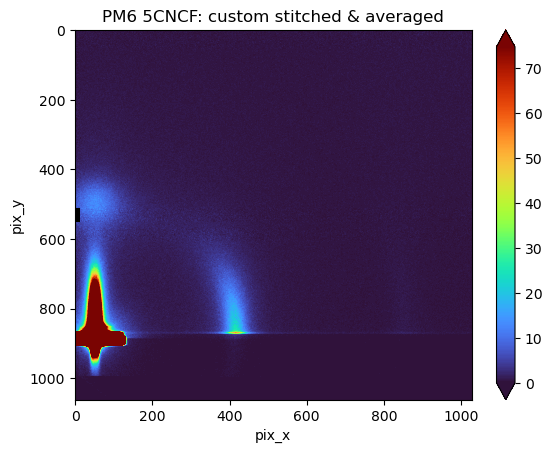

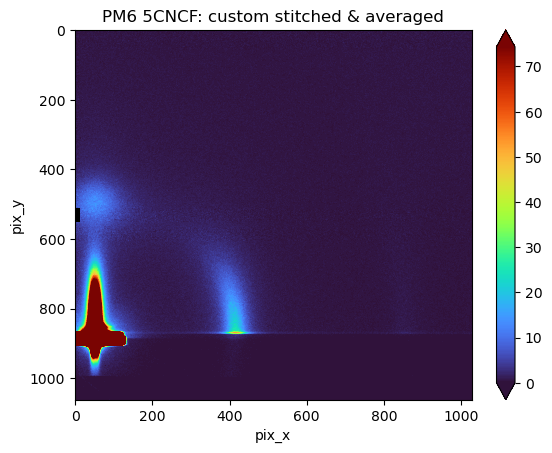

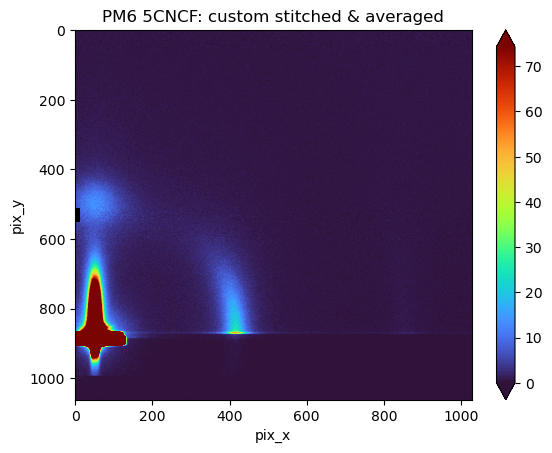

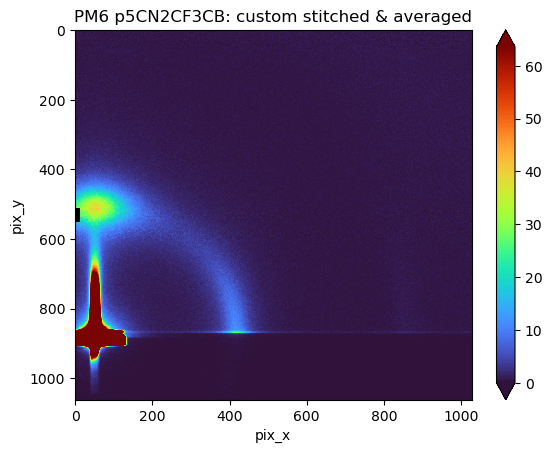

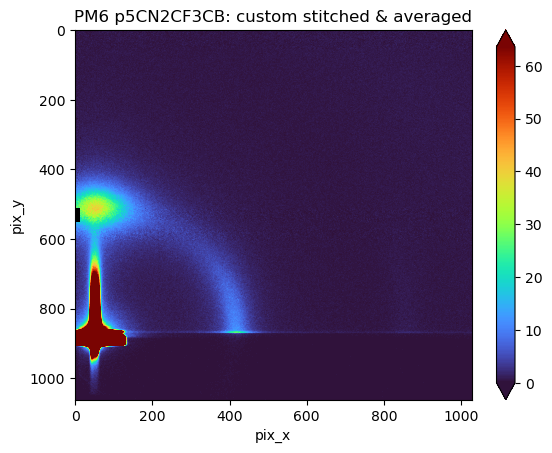

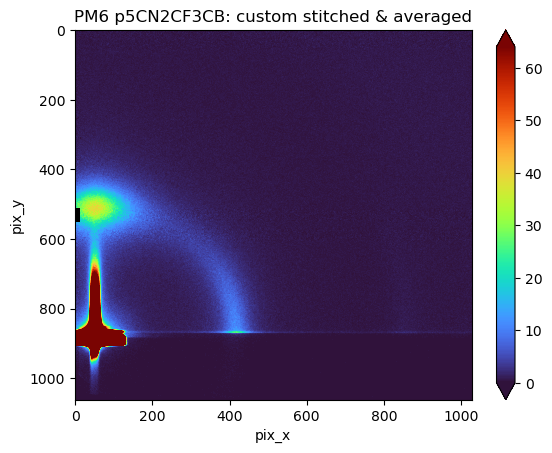

In [82]:
%matplotlib inline
plt.close('all')
# Plot check stitched DAs
for stitched_DA in stitched_DAs:
    cmin = stitched_DA.sel(pix_y=slice(None,895)).quantile(0.01)
    cmax = stitched_DA.sel(pix_y=slice(None,895)).quantile(0.99)
    ax = stitched_DA.plot.imshow(norm=plt.Normalize(cmin,cmax), origin='upper', cmap=cmap, interpolation='antialiased')
    ax.axes.set_title(f'{stitched_DA.material} {stitched_DA.solvent}: custom stitched & averaged')    
    plt.show()
    # plt.close('all') 

In [ ]:
# %matplotlib widget
# plt.close('all')
# # Plot check stitched DAs
# for stitched_DA in vd_DAs[4:5]:
#     ax = stitched_DA.sel(pix_y=slice(None,1061), pix_x=slice(None,1027)).plot.imshow(norm=plt.Normalize(cmin,cmax), origin='upper', cmap=cmap, interpolation='antialiased')
#     ax.axes.set_title(f"{stitched_DA.film}: default stitched output")    
#     plt.show()
#     # plt.close('all') 

In [ ]:
# %matplotlib widget
# plt.close('all')
# # Plot check stitched DAs
# for stitched_DA in hi_DAs[4:5]:
#     ax = stitched_DA.plot.imshow(norm=plt.Normalize(cmin,cmax), origin='upper', cmap=cmap, interpolation='antialiased')
#     ax.axes.set_title(f"{stitched_DA.film}: raw detector position")    
#     plt.show()
#     # plt.close('all') 

### Apply rotation corrections if necessary
Not very refined yet. Requires defining a dictionary of bottom_line_points for each image to rotate. e.g. {'DataArray_identifier': [(x1,y1), (x2, y2)]}

In [ ]:
# from scipy import ndimage

In [ ]:
# # Interactively plot data of selected sample to identify point coordinates
# plt.close('all')
# DA = stitched_DAs[0].copy()

# cmin=DA.quantile(0.2)
# cmax=DA.quantile(0.98)
# ax = DA.plot.imshow(norm=plt.Normalize(cmin,cmax), origin='upper', cmap=cmap)
# ax.axes.set_title(f'{DA.film}')    
# plt.show()

In [ ]:
# # Create dictionary containing points which define line by which to calculate amount to rotate from
# bottom_line_points - {}

In [ ]:
# pivot_poni = (713, 1251)
# def rotateImage(img, angle, pivot):
#     padX = [img.shape[1] - pivot[0], pivot[0]]
#     padY = [img.shape[0] - pivot[1], pivot[1]]
#     imgP = np.pad(img, [padY, padX], 'constant')
#     imgR = ndimage.rotate(imgP, angle, reshape=False)
#     return imgR[padY[0] : -padY[1], padX[0] : -padX[1]]

In [ ]:
# # Apply rotation corrections based on lines drawn between points

# rot_corr_DAs = []
# for DA in tqdm(stitched_DAs, desc='Rotating...'):  
#     # Get line points from dictionary
#     p1, p2 = bottom_line_points[f'{DA.sample_id}_{DA.exposure_time}']

#     # Calculate the angle from points
#     dx = p2[0] - p1[0]
#     dy = p2[1] - p1[1]
#     angle_radians = np.arctan2(dy, dx)
#     angle_degrees = np.degrees(angle_radians)

#     # Rotate image & save into list
#     rot_corr_DA = xr.apply_ufunc(rotateImage, DA, angle_degrees, pivot_poni)
#     # rot_corr_DA = xr.apply_ufunc(ndimage.rotate, DA, angle_degrees, (1, 0), False, None, 3, 'constant')
#     # rot_corr_DA = xr.apply_ufunc(ndimage.rotate, DA, 0, (1, 0), False)
#     rot_corr_DA.attrs = DA.attrs
#     rot_corr_DAs.append(rot_corr_DA)
    
# # Plot check
# for rot_corr_DA in rot_corr_DAs:
#     cmin = rot_corr_DA.quantile(0.2)
#     cmax = rot_corr_DA.quantile(0.99)
#     rot_corr_DA.plot.imshow(norm=plt.Normalize(cmin,cmax), origin='upper', cmap=cmap)
#     plt.show()
#     plt.close('all')

### Average between repeat scans if desired

In [83]:
scan1_DAs = [DA for DA in stitched_DAs if DA.attrs['scan_num']=='scan1']
scan2_DAs = [DA for DA in stitched_DAs if DA.attrs['scan_num']=='scan2']
scan3_DAs = [DA for DA in stitched_DAs if DA.attrs['scan_num']=='scan3']

In [86]:
avg_stitched_DAs = []
# for s1, s2 in zip(scan1_DAs, scan2_DAs):
#     avg_DA = (s1 + s2)/2
#     avg_DA.attrs = s1.attrs
#     avg_stitched_DAs.append(avg_DA)
for s1, s2, s3 in zip(scan1_DAs, scan2_DAs, scan3_DAs):
    avg_DA = (s1 + s2 + s3) / 3
    avg_DA.attrs = s1.attrs
    avg_stitched_DAs.append(avg_DA)
    
avg_stitched_DAs

[<xarray.DataArray (pix_y: 1062, pix_x: 1028)>
 array([[0.535505  , 0.6154873 , 0.        , ..., 0.64912146, 0.20340924,
         0.1792491 ],
        [0.5921147 , 0.46711257, 0.75403863, ..., 1.0263457 , 0.23678523,
         0.20085967],
        [0.20992756, 0.50649804, 0.27608564, ..., 0.5483339 , 0.2561176 ,
         0.43380186],
        ...,
        [0.22013061, 0.        , 0.2804615 , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.21051182, 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32)
 Coordinates:
   * pix_x    (pix_x) int64 0 1 2 3 4 5 6 ... 1021 1022 1023 1024 1025 1026 1027
   * pix_y    (pix_y) int64 0 1 2 3 4 5 6 ... 1055 1056 1057 1058 1059 1060 1061
 Attributes:
     material:        PM6
     solvent:         0CNCB
     sdd:             380sdd
     scan_num:        scan1
     misc:            0
     detector_pos:    00

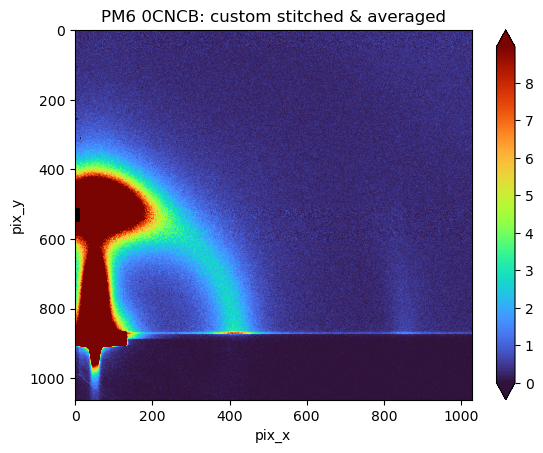

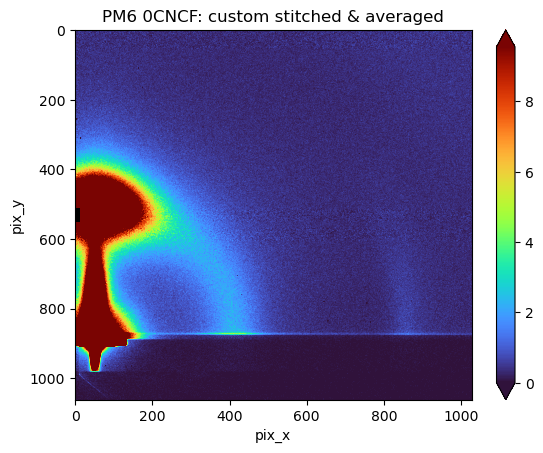

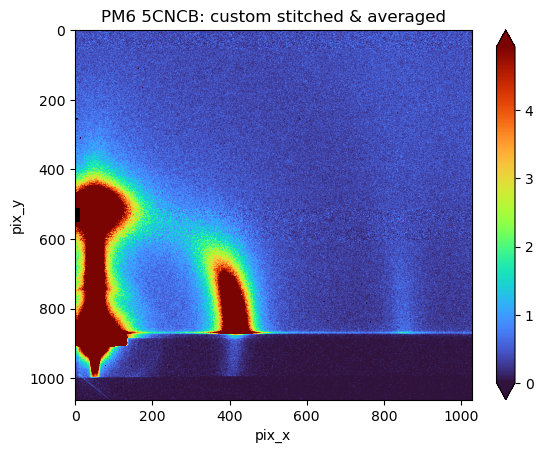

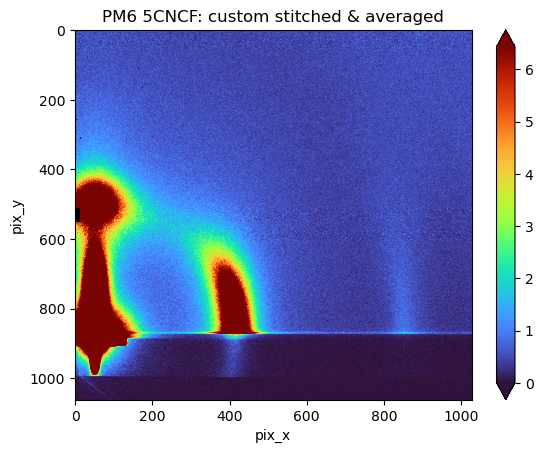

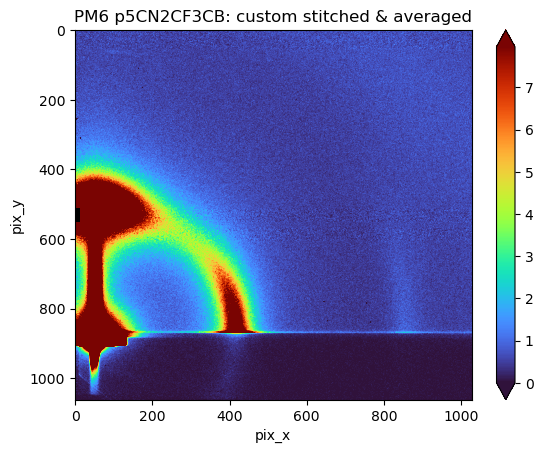

In [89]:
%matplotlib inline
plt.close('all')
# Plot check stitched DAs
for stitched_DA in avg_stitched_DAs:
    cmin = stitched_DA.sel(pix_y=slice(None,895)).quantile(0.001)
    cmax = stitched_DA.sel(pix_y=slice(None,895)).quantile(0.95)
    ax = stitched_DA.plot.imshow(norm=plt.Normalize(cmin,cmax), origin='upper', cmap=cmap, interpolation='antialiased')
    ax.axes.set_title(f'{stitched_DA.material} {stitched_DA.solvent}: custom stitched & averaged')    
    plt.show()
    # plt.close('all') 

### pygix-backed transformation

In [91]:
# Initialize integrators
# Don't forget to ensure the correct incident angle is set
incident_angle = stitched_DAs[0].incident_angle
recip_integrator = phs.integrate.PGGeneralIntegrator(geomethod = 'ponifile',
                                                     ponifile = poniFile,
                                                     output_space = 'recip',
                                                     incident_angle = incident_angle)
caked_integrator = phs.integrate.PGGeneralIntegrator(geomethod = 'ponifile',
                                                     ponifile = poniFile,
                                                     output_space = 'caked',
                                                     incident_angle = incident_angle)

In [92]:
# Use integrators to fill list of integrated DataArrays

recip_DAs = []
caked_DAs = []
for DA in tqdm(avg_stitched_DAs, desc='Transforming to reciprocal space'):   
    # Integrate single image
    recip_DA = recip_integrator.integrateSingleImage(DA)
    caked_DA = caked_integrator.integrateSingleImage(DA)

    # Append to corresponding list
    recip_DAs.append(recip_DA)
    caked_DAs.append(caked_DA)

Transforming to reciprocal space:   0%|          | 0/5 [00:00<?, ?it/s]

/var/folders/m1/v62q73kx1ylgb2vpydrxbyy40000gn/T/ipykernel_39273/3425549513.py:7: UserWarning: No mask defined. Creating an empty mask with dimensions (1062, 1028).
  recip_DA = recip_integrator.integrateSingleImage(DA)
/var/folders/m1/v62q73kx1ylgb2vpydrxbyy40000gn/T/ipykernel_39273/3425549513.py:8: UserWarning: No mask defined. Creating an empty mask with dimensions (1062, 1028).
  caked_DA = caked_integrator.integrateSingleImage(DA)


In [53]:
%matplotlib inline
plt.close('all')

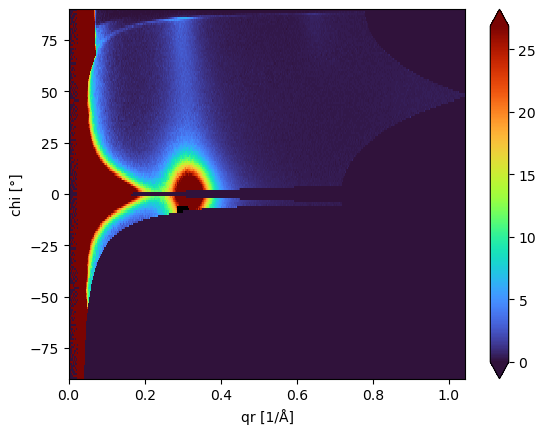

In [93]:
plt.close('all')
DA = caked_DAs[0].copy()

cmin = DA.sel(qr=slice(0.25,None)).quantile(0.01)
cmax = DA.sel(qr=slice(0.25,None)).quantile(0.995)
DA.plot.imshow(norm=plt.Normalize(cmin,cmax), cmap=cmap)
plt.show()

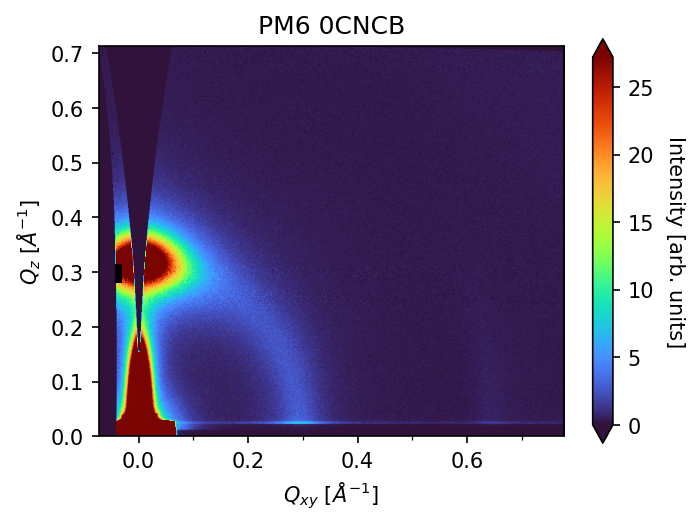

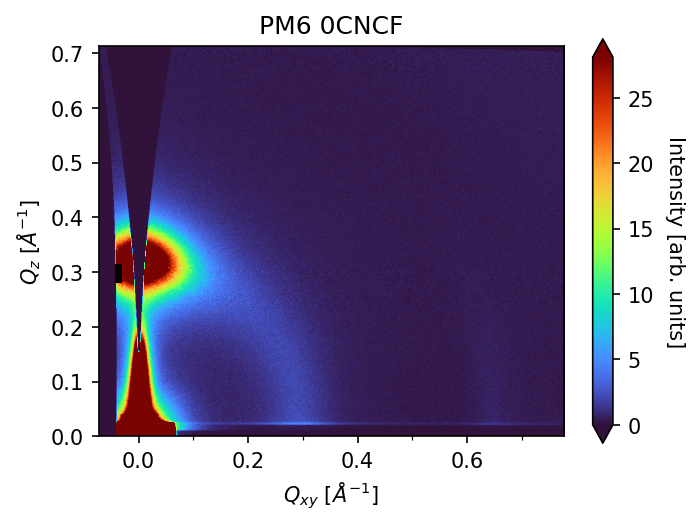

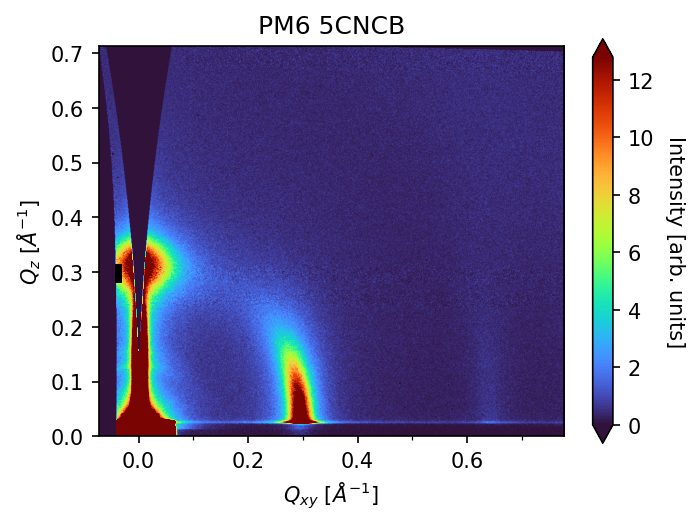

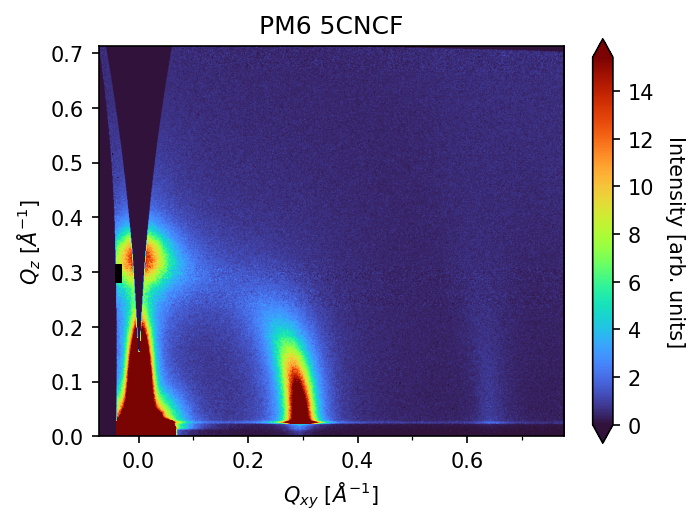

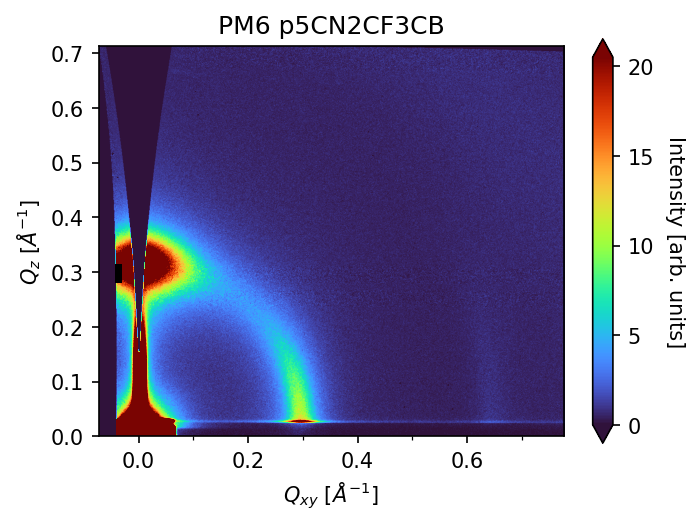

In [95]:
# Plot check recip DAs

# Set q bounds
qxy_min = -0.65
qxy_max = 2
qz_min = 0
qz_max = 2

for DA in recip_DAs:
# for DA in recip_DS.data_vars.values():
    sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min,qz_max))
    
    cmin = sliced_DA.quantile(0.01)
    cmax = sliced_DA.quantile(0.98)
    ax = sliced_DA.plot.imshow(norm=plt.Normalize(cmin,cmax), cmap=cmap, figsize=(5,3.5), interpolation='antialiased')
    ax.axes.set_title(f'{sliced_DA.material} {sliced_DA.solvent}')   
    ax.axes.set(aspect='equal', xlabel='$Q_{xy}$ $[\\AA^{-1}]$', ylabel='$Q_{z}$ $[\\AA^{-1}]$')
    ax.axes.xaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.axes.yaxis.set_minor_locator(plt.MultipleLocator(0.1))
    ax.colorbar.set_label('Intensity [arb. units]', rotation=270, labelpad=15)
    ax.figure.set(dpi=150)
    
    # # Save
    # savePath = outPath.joinpath('recip_images')
    # savePath.mkdir(exist_ok=True)
    # ax.figure.savefig(savePath.joinpath(f'{sliced_DA.material}_{sliced_DA.solvent}'), dpi=120)
    
    plt.show()
    plt.close('all') 

## Save / export processed data

### Save zarrs

In [96]:
# Stack data into a Datasets first:
raw_DS   = xr.Dataset({f'{DA.attrs['material']}_{DA.attrs['solvent']}': DA for DA in stitched_DAs})
recip_DS = xr.Dataset({f'{DA.attrs['material']}_{DA.attrs['solvent']}': DA for DA in recip_DAs})
caked_DS = xr.Dataset({f'{DA.attrs['material']}_{DA.attrs['solvent']}': DA for DA in caked_DAs})

In [60]:
outPath

PosixPath('/Users/andrew/Library/CloudStorage/OneDrive-UCB-O365/research/data_analysis/giwaxs_suite/processed_data/xenocs')

In [98]:
# Check savePath
# savePath = outPath.joinpath('PM6_2024C1_films_v1/zarrs')
savePath = outPath.joinpath('PM6_380sdd_2024C1_films_v1/zarrs')
savePath.exists()

True

In [99]:
# Save zarrs
recip_DS.to_zarr(savePath.joinpath('recip.zarr'))
raw_DS.to_zarr(savePath.joinpath('raw.zarr'))
caked_DS.to_zarr(savePath.joinpath('caked.zarr'))

### Numpy binary format

In [ ]:
# sliced_recip_DA = recip_DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min,qz_max))

# display(sliced_recip_DA.data.shape)
# display(sliced_recip_DA.q_xy.data.shape)
# display(sliced_recip_DA.q_z.data.shape)

In [ ]:
# npysPath = outPath.joinpath('npys')
# savePath = npysPath.joinpath(f'{sample_name}')
# savePath.mkdir(exist_ok=True)

# np.save(savePath.joinpath(f'data_{sample_name}.npy'), sliced_recip_DA.data)
# np.save(savePath.joinpath(f'qxy_{sample_name}.npy'), sliced_recip_DA.q_xy.data)
# np.save(savePath.joinpath(f'qz_{sample_name}.npy'), sliced_recip_DA.q_z.data)

In [ ]:
# data = np.load(savePath.joinpath(f'data_{sample_name}.npy'))
# plt.imshow(data, norm=plt.Normalize(cmin,cmax), origin='lower')
# plt.show()

### CSVs

In [ ]:
# # A way to save data as csv files
# for DA in tqdm(DS.data_vars.values()):
#     # qxy columns, qz rows
#     DA.to_pandas().to_csv(outPath.joinpath('PM6-Y6_waxs', f'cartesian-2D_{DA.polymer}-{DA.weight_percent}_{DA.incident_angle}_{DA.scan_id}.csv'))

## Misc 

### Yoneda check:

In [ ]:
def qz(wavelength, alpha_crit, alpha_incidents):
    qz_inv_meters = ((4 * np.pi) / (wavelength)) * (np.sin(np.deg2rad((alpha_incidents + alpha_crit)/2)))
    # qz_inv_meters = ((4 * np.pi) / (wavelength)) * (np.sin(np.deg2rad(alpha_crit)) + np.sin(np.deg2rad(alpha_incidents)))
    qz_inv_angstroms = qz_inv_meters / 1e10
    return qz_inv_angstroms

wavelength = 1.5420919527363186e-10  # 8.04 keV
# wavelength = 9.762535309700809e-11  # 12.7 keV
# wavelength = 1.2398419843320025e-10  # 10 keV

alpha_crit = 0.11  # organic film critical angle
alpha_incidents = np.array([0.15])

yoneda_angles = alpha_incidents + alpha_crit

qz(wavelength, alpha_crit, alpha_incidents)

In [ ]:
# %matplotlib widget

In [ ]:
# ax = recip_DS['sam6_2s'].plot.imshow(norm=plt.Normalize(cmin,cmax), cmap=cmap)
# ax.axes.set_title(f'{sliced_DA.sample_id}: {sliced_DA.exposure_time}')   
# ax.axes.set(aspect='equal')
# plt.show()

In [ ]:
# def select_attrs(data_arrays_iterable, selected_attrs_dict):
#     """
#     Selects data arrays whose attributes match the specified values.

#     Parameters:
#     data_arrays_iterable: Iterable of xarray.DataArray objects.
#     selected_attrs_dict: Dictionary where keys are attribute names and 
#                          values are the attributes' desired values.

#     Returns:
#     List of xarray.DataArray objects that match the specified attributes.
#     """    
#     sublist = list(data_arrays_iterable)
    
#     for attr_name, attr_values in selected_attrs_dict.items():
#         sublist = [da for da in sublist if da.attrs[attr_name] in attr_values]
                
#     return sublist

In [ ]:
# # Yoneda peak linecut check
# qxy_min = 0.22
# qxy_max = 2
# qz_min = -0.02
# qz_max = 0.06

# selected_DAs = select_attrs(fixed_recip_DS.data_vars.values(), selected_attrs_dict)
# for DA in tqdm(selected_DAs):
#     # Slice data for selected q ranges (will need to rename q_xy if dimensions are differently named)
#     sliced_DA = DA.sel(q_xy=slice(qxy_min, qxy_max), q_z=slice(qz_min, qz_max))
#     qz_integrated_DA = sliced_DA.sum('q_xy')
    
#     # Plot
#     qz_integrated_DA.plot.line(label=DA.incident_angle)
    
# plt.legend()
# plt.grid(visible=True, which='major', axis='x')
# plt.show()